This example shows how to use py2gcode to generate code to create lines from an SVG file, with a special focus on developing code to fuse lines used in inflatable fabric actuators. 

So the workflow in this notebook works as follows:

1. Load the SVG file
2. Explore the files, and find the curves.
3. Translate this vector description to coordinates.
4. Use py2gcode to create our custom made gcode. 


In [13]:
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import re

from svgpathtools import svg2paths2, Path, Line, QuadraticBezier, CubicBezier, Arc
from py2gcode import py2gcode

#%%
paths, attributes,svg_attributes  = svg2paths2('data/radial_pattern.svg')

We get 2 lists, paths, and attributes (they should have the same amount of elements), and a dictionary svg_atributes. In the next block, we implement a function to sample points along the curves with a given resolution. 

In [14]:
def tranverse_path(path,attribute,res = 0.4):
    """
    Transverse a given path for a given resolution
    
    Parameters
    ----------
    path : path to transverse
    attribute : dict with atributes (looking for transformations)
    res : step between points to resolve arcs or splines. The default is 0.8.

    Returns
    -------
    points : points in the path transvered

    """
    points = []
    z0 = 0 # translation stored in atributes
    if 'transform' in attribute:
        if 'translate' in attribute['transform']:
            values = re.findall(r"[-+]?(?:\d*\.*\d+)", attribute['transform'])
            z0 = complex(float(values[0]),float(values[1]))
            
    for seg in path._segments:
        if isinstance(seg,Line):
            points.append(seg.start+z0)
            points.append(seg.end+z0)
        else:
            n = round(seg.length(0,1)/res)
            if n != 0:
                ds = seg.length(0,1)/n
                for i in range(n):
                    t = seg.ilength(ds*i)
                    points.append(seg.point(t)+z0)
                points.append(seg.point(1)+z0)
    return np.array(points)

(22.338599999999985, 192.8386, 8.441980699999972, 195.4486533)

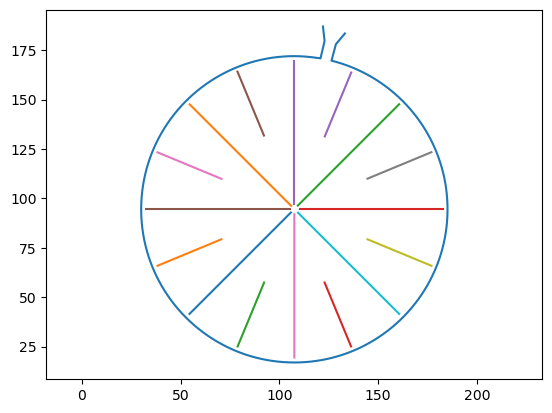

In [15]:
# use the function tranverse paths for all elements.
shapes = []
for path,attribute in zip(paths,attributes):
    points = tranverse_path(path,attribute)
    shapes.append(points)
    plt.plot(np.real(points),np.imag(points))
plt.axis('equal')

We can see, origin of drawing have a big offset, lets find the bounding box of biggest shape, in this case is the first one, also we will add a small offset of 5 mm 

(-2.7500000000000018,
 167.75000000000003,
 -3.5003033000000006,
 183.50636930000002)

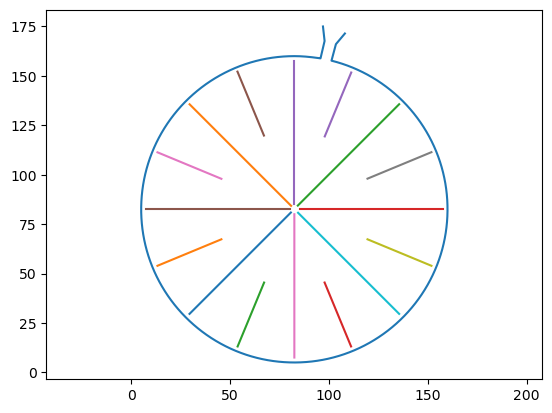

In [22]:
x0,_,y0,_ = paths[0].bbox()
offset = 5.0
new_cordinates = []
for shape in shapes:
    plt.plot(np.real(shape)-x0+offset,np.imag(shape)-y0+offset)
    new_cordinates.append(shape+(x0+offset+(y0+offset)*1j))

plt.axis('equal')

At last we will translate this path to gcode, we start by homing the machine then we transverse all the paths, we lift the tip to reposition in every movement 10. mm

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

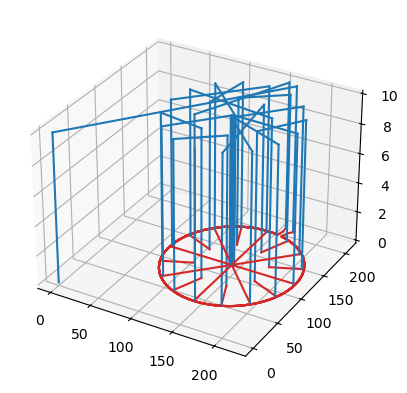

In [26]:
pgcode = py2gcode()
pgcode.go_home()
z_rep = 10.0
pgcode.move_abs(z = 10.0)
pgcode.line_diameter = 0.0
pgcode.feed = 100 # speed of movement, used or the working movements

for coords in new_cordinates:
    p = coords[0]
    pgcode.move_abs(x =np.real(p) ,y = np.imag(p))
    pgcode.move_abs(z = 0.0)
    for pi in coords[1:]:
        pgcode.move_abs(x =np.real(pi) ,y = np.imag(pi),extrude= True) # we use this argument just to paint a change the movement speed
    pgcode.move_abs(z = 10.0)
pgcode.plot() # with a arbitrary aspect ratio
pgcode.out('tranversed_path') # export the with a given name